###### Материал распространяется по лицензии Creative Commons Attribution license, CC-BY 4.0; code under MIT license.  (c)2014 Lorena A. Barba,  Olivier Mesnard. Благодарности: NSF for support via CAREER award #1149784.

##### Версия 0.1 -- Март 2015

# Панельный метод источников

Курс *AeroPython* выходит на финишную прямую! На первых занятиях мы рассмотрели несколько элементарных потенциальных течений и научились использовать всю мощь принципа суперпозиции. И при помощи этих знаний получили некоторые полезные с точки зрения аэродинамики результаты.

При наложении [диполя](03_Lesson03_doublet.ipynb) на равномерный поток получилось обтекание кругового цилиндра, а мы узнали о *парадоксе Д'Аламбера*: сопротивление цилиндра в потоке жидкости равно нулю. Добавив в центр круга [вихрь](06_Lesson06_vortexLift.ipynb) мы познакомились с подъемной силой и *теоремой Кутты-Жуковского*, согласно которой подъемная сила пропорциональна циркуляции: $L=\rho U \Gamma$. Это важнейший результат!

Сложение элементарных потенциальных течений и интерпретация получившейся картины течения как обтекания твердого тела, контуры которого образованы разделительной линией тока, обычно называют *непрямым методом*. Этот метод восходит к Рэнкину, а это 1871 год! Но он имеет ограниченную применимость, поскольку невозможно найти походящее решение для наперед заданной геометрии.

В [девятом занятии](09_Lesson09_flowOverCylinder.ipynb) мы убедились, что произвольную геометрию можно разбить на панели, поместить на них распределенные источники и подобрать их интенсивности таким образом, чтобы направление потока было касательным к границе тела. Такой подход называется *прямым методом*, он появился в 1960-х в работах Гесса и Смита, выполненных для Douglas Aircraft Company.

Набором панелей (в двумерном случае, отрезков) и связанными с ними слоями источников, интенсивность которых определяется из условия равенства нулю нормальной компоненты скорости, можно представить поверхность любого твердого тела, помещенного в потенциальное течение. Это очень мощная идея! Нужно только помнить, что интенсивности панелей связаны между собой, и это приводит к необходимости решать систему линейных уравнений.

Для произвольной геометрии, мы должны построить набор панелей по некоторым точкам, которые определяют геометрию. На этом занятии мы зачитаем из файла геометрию профиля **NACA0012**, создадим набор панелей и решим систему уравнений для определения интенсивностей слоев источников, что позволит нам получить обтекание профиля.

* *Убедитесь, что вы изучили [Занятие 9](09_Lesson09_flowOverCylinder.ipynb) тщательно прежде чем продолжить!* Мы не будем повторять все математические выкладки в этом блокноте, так что обращайтесь к пройденному материалу по мере необходимости.

Для начала загрузим наши любимые библиотеки, а также модуль `integrate` из SciPy:

In [1]:
import os
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
# помещаем графику внутрь блокнота
%matplotlib inline

Затем зачитаем геометрию профиля из файла, используя функцию [`loadtxt()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html). Файл с геометрией был взят с сайта [Airfoil Tools](http://airfoiltools.com/airfoil/details?airfoil=n0012-il) и содержит набор координат стандартного симметричного профиля NACA0012. Локальная копия файла с геометрией находится в директории `resources`.

Точки геометрии загружаются в один массив numpy, а мы разделим эти данные на два массива: `x,y` для удобства. При помощи следующих строчек кода мы нарисуем профиль. 

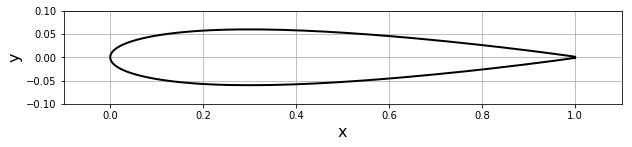

In [2]:
# зачитываем геометрию из файла с данными
naca_filepath = os.path.join('resources', 'naca0012.dat')
with open (naca_filepath, 'r') as file_name:
    x, y = numpy.loadtxt(file_name, dtype=float,\
                         delimiter='\t', unpack=True)

# рисуем геометрию
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

## Разбиение на панели

Как и в [Занятии 9](09_Lesson09_flowOverCylinder.ipynb), создадим разбиение геометрии на панели (в нашем, двуменрном, случае — на отрезки). У панелей будут такие характеристики (атрибуты): начальная и конечная точки, середина, длина и ориентация. На рисунке ниже приведены условные обозначения — имена переменных, которые мы будем использовать в коде.

<img src="./resources/panelSketch.png" width="400">

Мы слегка изменим класс `Panel` из предыдущего блокнота, подгоним его под новую задачу — изучение обтекания профиля. Единственное изменение — принадлежность точки к верхней или нижней поверхности обозначим признаками `upper` и `lower`. Это нам пригодится позже, мы сможем нарисовать результаты для верхней и нижней поверхностей разными цветами.

In [3]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is on the lower or upper surface of the geometry.
        Initializes the source-sheet strength, tangential velocity,
        and pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        # контрольная точка (центр панели)
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2 
        # длина панели
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     
        
        # ориентация панели (угол между нормалью и осью x)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # положение панели
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.                         # интенсивность источника
        self.vt = 0.                            # касательная скорость
        self.cp = 0.                            # коэффициент давления

В случае кругового цилиндра разбиение на панели выглядело очень просто. Именно эта часть усложняется при переходе к произвольной геометрии, в то время как часть метода, ответственная за решение, остается такой же, как и в [Занятии 9](09_Lesson09_flowOverCylinder.ipynb).

Функция, приведенная ниже, создает панели, исходя из геометрических данных, которые была прочитаны из файла. На передней и задней кромках, где большая кривизна, лучше сделать панели помельче. Один из способов получения неравномерного распределения панелей по профилю — сначала дискретизировать круг с диаметром, равным хорде профиля, касающийся передней и задней кромок, как показано на следующем рисунке.

<img src="./resources/naca0012_in_circle.png" width="300">

Затем, сохранить значения $x$-координат точек окружности, `x_circle`, которые станут $x$-координатами узлов панелей, `x`, и спроецировать $y$-координаты точек окружности на профиль при помощи интерполяции. В итоге получится распределение узлов на профиле, со сгущением к передней и задней кромкам. Выглядит это так:

<img src="./resources/naca0012_discretized_in_circle.png" width="300">

Описанный способ разбиения реализовани в функции `define_panels()`, она получает на вход желаемое число панелей и набор координат, а выдает массив объектов класса `Panel`, содержащих всю информацию о каждой панели.

Несколько замечаний о реализации функции `define_panels()`:

* только $x$-координаты точек окружности (`x_circle`) нужно вычислить, поскольку $y$-координаты узлов панелей будут определены при помощи интерполяции;
* для построения окружности создается `N+1` точка, но первая и последняя точки совпадают;
* расширение массивов происходит простым добавлением дополнительных элементов с известными значениями (они равно значению нулевых элементов), поэтому в циклах элементы `x[i+1]` не участвуют;
* цикл *while* используется для поиска двух соседниех точек на профиле, (`x[I]`,`y[I]`) и (`x[I+1]`,`y[I+1]`), таких, чтобы в интервале [`x[I]`,`x[I+1]`] лежало значение координаты `x_ends[i]`. Для выхода из цикла используется ключевое слово `break`;
* когда определены две нужные точки, значение `y_ends[i]` рассчитывется при помощи интерполяции.

In [4]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    R = (x.max()-x.min())/2                         # радиус окружности
    x_center = (x.max()+x.min())/2                  # x-координата центра
    # x-координаты точек окружности
    x_circle = x_center + R*numpy.cos(numpy.linspace(0, 2*math.pi, N+1))  
    # проекция x-координаты на поверхность профиля
    x_ends = numpy.copy(x_circle)      
    # инициализация массива c y-координатами
    y_ends = numpy.empty_like(x_ends)  
    # добавляем к массиву точки, используя numpy.append
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])    
    
    # вычисляем y-координаты концов отрезков
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or \
            (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

Теперь можно воспользоваться этой функцией, при выполнении следующей ячейки функция вызывается с необходимым числом панелей в качестве параметра. И еще нарисуем конечную геометрию.

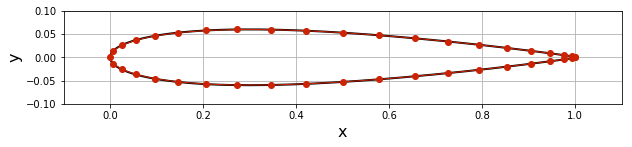

In [5]:
N = 40                            # число панелей
panels = define_panels(x, y, N)   # разбиваем геометрию на панели

# рисуем исходную геометрию и панели
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6,\
            color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

## Параметры набегающего потока

Профиль NACA0012 будет помещен в равномерный поток со скоростью $U_\infty$ и углом атаки $\alpha=0$. Хотя создание отдельного класса для невозмущенного течения может показаться лишним, мы все равно это сделаем. Создавая класс, мы предполагаем, что понадобится несколько объектов такого класса. Здесь же нам нужен только один набегающий поток, зачем же такие сложности? Вообще, это делает код более читабельным и позволяет программисту использовать имена переменных `u_inf` и `alpha` для чего-то еще за пределами класса.
Кроме того, каждый раз, когда нам понадобится передать параметры набегающего потока в качестве входных данных для функции, мы просто можем передать объект в качестве аргумента а не все параметры течения по отдельности.

In [6]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180          # градусы --> радианы

In [7]:
# задаем параметры набегающего потока
# и определяем ими объект нужного класса
u_inf = 1.0                                # скорость потока
alpha = 0.0                                # угол атаки (в градусах)
# инициализация объекта класса freestream
freestream = Freestream(u_inf, alpha)      

## Граничное условие для потока на поверхности тела

Обеспечение касательности скорости в *контрольных точках* делает контур тела разделительной линией тока в некотором приближении, при этом точность такого приближения увеличивается по мере роста количества панелей. Итак, для каждой панели $i$, нужно обеспечить $u_n=0$ в точке , $(x_{c_i},y_{c_i})$, что приводит к системе уравнений, которую мы вывели на прошлом занятии:

\begin{equation}
u_{n_i} = \frac{\partial}{\partial n_i}\left\lbrace \phi\left(x_{c_i},y_{c_i}\right) \right\rbrace = 0
\end{equation}

то есть

\begin{equation}
0 = U_\infty \cos\beta_i + \frac{\sigma_i}{2} + \sum_{j=1,j\neq i}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i
+ \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j
\end{equation}

В приведенном выше уравнении, мы вычисляем производную потенциала по нормали для обеспечения касательности потока на каждой панели. Но позже нам предстоит вычислять еще и производную по касательной для определения коэффициента давления. А если нам потебуется отобразить поле скоростей на в узлах расчетной сетки, то нужно будет еще вычислить и производные по $x$- и $y$-кординатам.

Поэтому функция, приведенная ниже, аналогична реализованной в [Занятии 9](09_Lesson09_flowOverCylinder.ipynb) для вычисления значений интеграла на каждой панели, но теперь мы обобщили ее на случай разных направлений производных (при помощи двух новых аргументов `dxdz` and `dydz`, которые представляют значения $\frac{\partial x_{c_i}}{\partial z_i}$ and $\frac{\partial y_{c_i}}{\partial z_i}$,  где $z_i$ — нужное направление).

Более того, новая функция более общая еще и потому, что позволяет получать значения в любой точке панели, а не только в центре (вместо аргумента `p_i` появились координаты контрольной точки `x` и `y`, а `p_j` заменили на `panel`).

In [8]:
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz
                  +(y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2
                   +(y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

## Построение системы линейных уравнений

В этом разделе мы сосавим и решим систему линейных уравнений в виде

\begin{equation}[A][\sigma] = [b].\end{equation}

При создании матрицы, мы будем вызывать функцию `integral()` с нужными значениями последних параметров: $\cos \beta_i$ и $\sin\beta_i$, соответствующими производным по нормали.

Наконец, мы воспользуемся `linalg.solve()` из NumPy для решения системы уравнений и орпеделим интенсивность для каждой панели.

In [9]:
def build_matrix(panels):
    """
    Builds the source matrix.
    
    Parameters
    ----------
    panels: 1D array of Panel object
        The source panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        The source matrix (NxN matrix; N is the number of panels).
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc,\
                                              p_j, math.cos(p_i.beta),\
                                              math.sin(p_i.beta))
    
    return A

def build_rhs(panels, freestream):
    """
    Builds the RHS of the linear system.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        RHS of the linear system.
    """
    b = numpy.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    
    return b

In [10]:
A = build_matrix(panels)            # вычисляем матрицу особенностей
b = build_rhs(panels, freestream)   # вычисляем столбец правых частей

In [11]:
# решаем систему уравненй
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

## Коэффициент давления на поверхности

Согласно уравнению Бернулли, коэффициент давления на $i$-ой панели равен

\begin{equation}C_{p_i} = 1-\left(\frac{u_{t_i}}{U_\infty}\right)^2
\end{equation}

где $u_{t_i}$ — касательная компонента скорости в центре $i$-ой панели,

\begin{equation}
u_{t_i} = -U_\infty \sin\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \frac{\partial x_{c_i}}{\partial t_i}
+ \left(y_{c_i}-y_j(s_j)\right) \frac{\partial y_{c_i}}{\partial t_i}
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j
\end{equation}

учитывая, что

\begin{equation}
\frac{\partial x_{c_i}}{\partial t_i} = -\sin\beta_i \quad\text{and} \quad \frac{\partial y_{c_i}}{\partial t_i} = \cos\beta_i
\end{equation}

Обратите внимание, что ниже мы вызываем функцию `integral()` с другими аргументами: $-\sin\beta_i$ и $\cos\beta_i$, чтобы получить производную по касательной.

In [12]:
def get_tangential_velocity(panels, freestream):
    """
    Computes the tangential velocity on the surface of the panels.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j,\
                                              -math.sin(p_i.beta),\
                                              math.cos(p_i.beta))
    
    b = freestream.u_inf * \
    numpy.sin([freestream.alpha - panel.beta for panel in panels])
    
    sigma = numpy.array([panel.sigma for panel in panels])
    
    vt = numpy.dot(A, sigma) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [13]:
# вычисляем касательныю скорость в центрах панелей
get_tangential_velocity(panels, freestream)

In [14]:
def get_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients on the panels.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [15]:
# вычисляем коэффициент давления на поверхности
get_pressure_coefficient(panels, freestream)

### Теоретическое решение

Существует классический способ получить теоретические характеристики крыльевых профилей, известный как метод *Теодорсена*. Метод основан на преобразовании Жуковского, но может применяться к настоящим профилям, так как в нем имеется дополнительное отображение из "почти окружности" в окружность. Метод довольно кучерявый! Но итоговые значения коэффициента давления для некоторых профилей затабулированы в 1945 году в [отчете NACA №824](http://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19930090976.pdf) и доступны на сайте NASA. Нужные нам данные находятся на странице 71.

В таблице представлены значения $(u/U_{\infty})^2$ в нескольких точках по хорде профиля. Выведем их здесь и сохраним в массив:

In [16]:
voverVsquared=numpy.array([0, 0.64, 1.01, 1.241,\
                           1.378, 1.402, 1.411, \
                           1.411, 1.399, 1.378, \
                           1.35, 1.288, 1.228, \
                           1.166, 1.109, 1.044, 0.956, 0.906, 0])
print(voverVsquared)

[0.    0.64  1.01  1.241 1.378 1.402 1.411 1.411 1.399 1.378 1.35  1.288
 1.228 1.166 1.109 1.044 0.956 0.906 0.   ]


In [17]:
xtheo=numpy.array([0, 0.5, 1.25, 2.5, 5.0, 7.5,\
                   10, 15, 20, 25, 30, 40, 50, 60,\
                   70, 80, 90, 95, 100])
xtheo = xtheo/100
print(xtheo)

[0.     0.005  0.0125 0.025  0.05   0.075  0.1    0.15   0.2    0.25
 0.3    0.4    0.5    0.6    0.7    0.8    0.9    0.95   1.    ]


### И нарисуем результат!

Воспользуемся данными из отчета NASA (они также опубликованы в книге Эббота и Доэнхоффа ["Theory of Wing Sections,"](http://books.google.com/books/about/Theory_of_Wing_Sections_Including_a_Summ.html?id=DPZYUGNyuboC) 1949), чтобы сопоставить их с результатами расчета по панельному методу источников. Давайте посмотрим, как это выглядит!

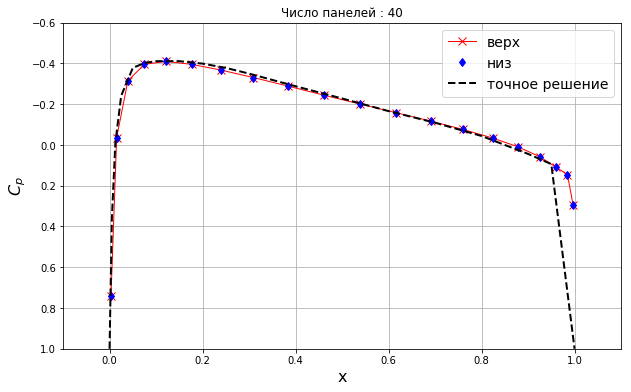

In [18]:
# рисуем коэффициент давления на поверхности профиля
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='верх',
            color='r', linewidth=1, marker='x', markersize=8)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label='низ',
            color='b', linewidth=0, marker='d', markersize=6)
pyplot.plot(xtheo, 1-voverVsquared,
            label='точное решение',
            color='k', linestyle='--',linewidth=2)
pyplot.legend(loc='best', prop={'size':14})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -0.6)
pyplot.title('Число панелей : %d' % N);

Довольно неплохо! Единственное место, где панельный метод не совсем соответствует табличным данным, полученным по методу Теодорсена, это задняя кромка. Но учтите, что граничное условия непротекания в панельном методе выполняется в контрольных точках панели (а не на концах), поэтому такое расхождение не удивительно.

##### Проверка точности

Для замкнутого тела суммарная интенсивность всех источников должна равняться нулю. В противном случае тело добавляло бы в поток какую-то массу, или наоборот, что-то забирало бы. Поэтому, должно выполняться

$$\sum_{j=1}^{N} \sigma_j l_j = 0$$

где $l_j$ — длина $j^{\text{ой}}$ панели.

Зная это, можно оценить точность панельного метода источников.

In [19]:
# вычисляем точность
accuracy = sum([panel.sigma*panel.length for panel in panels])
print('--> суммарная интенсивность источников/стоков: {}'.format(accuracy))

--> суммарная интенсивность источников/стоков: 0.004617031175283105


## Линии тока

Чтобы построить линии тока, нужно создать сетку (как мы делали на каждом занятии курса *AeroPython*!) и вычислить значения скоростей в ее узлах. Зная интенсивность каждой панели, мы находим $х$-компоненту скорости, взяв производную от потенциала скорости по переменной $x$, и $y$-компоненту путем взятия производной по $y$:

$$u\left(x,y\right) = \frac{\partial}{\partial x}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

$$v\left(x,y\right) = \frac{\partial}{\partial y}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

Обратите внимание, что при вычислении производных по переменной $x$ мы вызываем функцию `integral()` с $1,0$, в качестве последних аргументов , и $0,1$ для производных по $y$.

Кроме того, мы используем функцию `numpy.vectorize()` (как и в [Занятии 8](08_Lesson08_sourceSheet.ipynb)), чтобы избавиться от вложенного цикла по всей расчетной области.

In [20]:
def get_velocity_field(panels, freestream, X, Y):
    """
    Computes the velocity field on a given 2D mesh.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    X: 2D Numpy array of floats
        x-coordinates of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    # вклад от набегающего потока
    u = freestream.u_inf * math.cos(freestream.alpha) *\
    numpy.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) *\
    numpy.ones_like(X, dtype=float)
    # добавляем вклад от каждой панели (суперпозиция рулит!!!)
    vec_intregral = numpy.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * \
        vec_intregral(X, Y, panel, 1, 0)
        v += panel.sigma / (2.0 * math.pi) * \
        vec_intregral(X, Y, panel, 0, 1)
    
    return u, v

In [21]:
# определяем параметры сетки
nx, ny = 20, 20  # количество узлов в x и y направленях
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
                      numpy.linspace(y_start, y_end, ny))

# рассчитываем поле скоростей в узлах расчетной сетки
u, v = get_velocity_field(panels, freestream, X, Y)

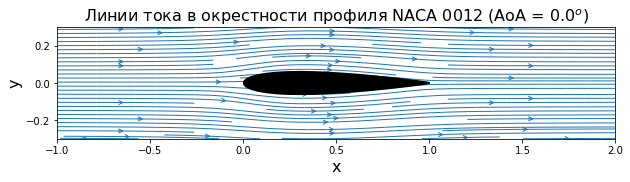

In [22]:
# рисуем поле скорости
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
title = 'Линии тока в окрестности профиля NACA 0012 (AoA = ${}^o$)'
pyplot.title(title.format(alpha), fontsize=16);

Теперь мы можем рассчитать коэффициент давления. На занятии 9 мы вычислили коэффициент давления на поверхности кругового цилиндра. Это было полезно, потому что у нас есть аналитическое решение для давления на поверхности цилиндра в потенциальном потоке. В случае профиля интересно было бы посмотреть, как выглядит давление в окрестности профиля, поэтому мы построим контурный график в расчетной области.

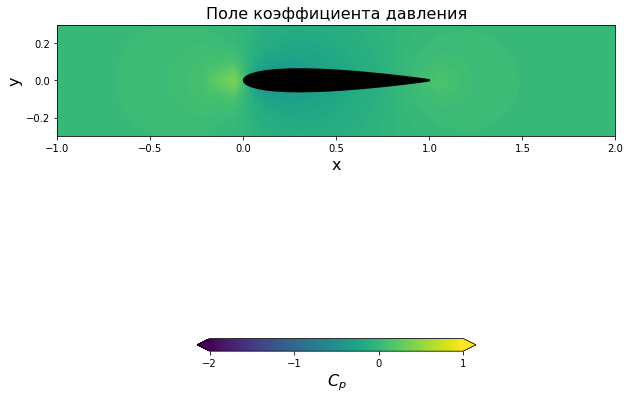

In [23]:
# рассчитываем поле давления
cp = 1.0 - (u**2+v**2)/freestream.u_inf**2

# рисуем поле давления
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp,
                        levels=numpy.linspace(-2.0, 1.0, 100),\
                        extend='both')
cbar = pyplot.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.title('Поле коэффициента давления', fontsize=16);

## Заключительные замечания

Мы научились использовать слой  источников для представления любого твердого тела: сначала [кругового цилиндра](09_Lesson09_flowOverCylinder.ipynb) (который, как известно, можно было бы получить путем суперпозиции диполя и равномерного потока), а теперь и аэродинамического профиля.

Но в чем особенность профилей, что делает их интересными? Ну, то, что мы можем использовать их для создания подъемной силы, собственно то, что заставляет их летать, конечно! Но что же нам нужно для создания подъемной силы? Подумайте, подумайте ... ничего не приходит на ум?

## Литература

1. [Airfoil Tools](http://airfoiltools.com/index), сайт с данными по профилям.
1. Ira Herbert Abbott, Albert Edward Von Doenhoff and Louis S. Stivers, Jr. (1945), "Summary of Airfoil Data," NACA Report No.824, [PDF on the NASA web server](http://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19930090976.pdf) (см. стр. 71)
1. Ira Herbert Abbott, Albert Edward Von Doenhoff, "Theory of Wing Sections, Including a Summary of Airfoil Data" (1949), Dover Press.

Ссылка на метод Теодорсена:

* Roland Schinzinger, Patricio A. A. Laura (1991), "Conformal Mapping: Methods and Applications." Dover edition in 2003. [Доступно на Google Books](https://books.google.com/books?id=qe-7AQAAQBAJ&lpg=PA128&ots=wbg0jLlqq5&dq=method%20theodorsen&pg=PA128#v=onepage&q=%22method%20of%20theodorsen%20and%20garrick%22&f=false)

---

###### Пожалуйста, не обращайте внимания на ячейку ниже. При её исполнении загружаются стили для отображения блокнота.

In [24]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()